In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw6.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 6: Clustering
### Associated lectures: Lectures 15 and 16

**Due date: Check the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html)**

## Imports <a name="im"></a>

In [2]:
import os
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:6}

**Please be aware that this homework assignment requires installation of several packages in your course environment. It's possible that you'll encounter installation challenges, which might be frustrating. However, remember that solving these issues is not wasting time but it is an essential skill for anyone aspiring to work in data science or machine learning.**

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 4. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb. If the pdf or html also fail to render on Gradescope, please create two files for your homework: hw6a.ipynb with Exercise 1 and hw6b.ipynb with Exercises 2 and 3 and submit these two files in your submission.  
</div>

_Points:_ 6

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 1: Document clustering warm-up
<hr>

In this homework, we will explore a popular application of clustering called [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A, tweets), and clustering is a commonly used technique to organize this data in a meaningful way. 

As a warm up, in this exercise you will cluster sentences from a toy corpus. Later in the homework you will work with a real corpus. 

The code below extracts introductory sentences of Wikipedia articles on a set of queries. To run the code successfully, you will need the `wikipedia` package installed in the course environment. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```


**Your tasks:**

Run the code below which 
- extracts content of Wikipedia articles on a set of queries
- tokenizes the text (i.e., separates sentences) and 
- stores the 2nd sentence in each article as a document representing that article

> Feel free to experiment with Wikipedia queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs to grade your submission.

> For tokenization we are using the `nltk` package. If you do not have this package in the course environment, you will have to install it.

```
conda activate cpsc330
conda install -c anaconda nltk
```

Even if you have the package installed via the course `conda` environment, you might have to download `nltk` pre-trained models, which can be done with the code below.

In [3]:
import nltk

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cedar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cedar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "baguette food",
    "banana bread food",
    "bread food",
    "data science",
    "sports analytics",
    "football sport",
    "ice hockey",
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    text = sent_tokenize(wikipedia.page(queries[i]).content)[1]
    wiki_dict["text"].append(text)
    wiki_dict["n_words"].append(len(word_tokenize(text)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,baguette food,It is distinguishable by its length and crisp crust.,10
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17
6,ice hockey,It belongs to a family of sports called hockey.,10


Our toy corpus has six toy documents (`text` column in the dataframe) extracted from Wikipedia queries. 

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many clusters? 
rubric={points}


**Your tasks:**

1. If you are asked to cluster the documents from this toy corpus manually, how many clusters would you identify and how would you label each cluster?   

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 1

I would expect to see the following 3 clusrters:
1. Food
2. Data Science
3. Sports

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 `KMeans` with bag-of-words representation 
rubric={points}

In the lecture, we saw that data representation plays a crucial role in clustering. Changing flattened representation of images to feature vectors extracted from pre-trained models greatly improved the quality of clustering. 

What kind of representation is suitable for text data? We have used bag-of-words representation to numerically encode text data before, where each document is represented with a vector of word frequencies. 

Let's try clustering documents with this simplistic representation.  

**Your tasks:**

1. Create bag-of-words representation using [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with default arguments for the `text` column in `wiki_df` above.
2. Cluster the encoded documents with [`KMeans` clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Use `random_state=42` (for reproducibility) and set `n_clusters` to the number you identified in the previous exercise.
3. Store the clustering labels in `kmeans_bow_labels` variable below. 

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

In [5]:
# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bag_of_words = pd.DataFrame(vectorizer.fit_transform(wiki_df["text"]).toarray(), columns=vectorizer.get_feature_names_out())
bag_of_words

,2011,ability,also,an,analytics,and,application,are,around,been,...,technology,term,the,throughout,to,underlying,use,was,world,yeast
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,1,0,0,1,1,...,0,0,1,1,0,0,0,0,1,0
3,0,0,1,0,0,1,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,1,3,0,0,0,0,1,0,0
5,0,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [6]:
from sklearn.cluster import KMeans

kmeans_bow_labels = KMeans(n_clusters=3, random_state=42).fit_predict(bag_of_words)
kmeans_bow_labels

array([1, 2, 0, 1, 1, 1, 1], dtype=int32)

In [7]:
wiki_df["bow_kmeans"] = kmeans_bow_labels
wiki_df

,wiki query,text,n_words,bow_kmeans
0,baguette food,It is distinguishable by its length and crisp crust.,10,1
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,2
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,0
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,1
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,1
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,1
6,ice hockey,It belongs to a family of sports called hockey.,10,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Sentence embedding representation
rubric={points}

Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer and more expressive representations of text which can be extracted using transfer learning. In this lab, we will use one such representation called sentence embedding representation, which uses deep learning models to generate dense, fixed-length vector representations for sentences. We will extract such representations using sentence transformer package. Sentence embedding takes into account context of words and semantic meaning of sentences and it is likely to work better when we are interested in clustering sentences based on their semantic similarity. 

```
conda activate cpsc330
conda install pytorch::pytorch torchvision torchaudio -c pytorch
conda install -c conda-forge sentence-transformers
```

**Your tasks:**

1. Run the code below to create sentence embedding representation of documents in our toy corpus. 
2. Cluster documents in our toy corpus encoded with this representation (`emb_sents`) and `KMeans` with following arguments: 
    - `random_state=42` (for reproducibility)
    - `n_clusters`=the number of clusters you identified in 1.1
3. Store the clustering labels in `kmeans_emb_labels` variable below. 

In [8]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

# If this cell gives an error, try updating transformers with
# pip install transformers -U

C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [9]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.186268,0.286701,0.058714,0.095216,-0.136911,0.091687,-0.029694,-0.104941,0.174888,0.482772,...,0.025579,-0.078821,0.470531,-0.209694,-0.379226,0.409230,-0.299176,0.155533,0.309284,0.124819
1,-0.202058,0.320748,0.190347,0.232201,0.600542,0.376622,-0.018205,-0.027148,-0.076679,0.381883,...,0.213062,-0.080009,0.422756,0.072725,0.016024,-0.014596,-0.202858,-0.162947,-0.190418,-0.002013
2,-0.022418,0.217159,0.022694,0.003616,0.240857,0.358046,-0.053310,-0.328075,0.190012,0.244470,...,0.265413,-0.415595,0.003036,0.052483,0.345947,0.110091,0.405441,0.197792,-0.058254,0.212376
3,0.270839,0.187923,-0.010779,0.318688,-0.092012,-0.204805,0.038100,-0.117648,0.084057,-0.170613,...,0.069944,-0.222987,0.092472,0.309445,0.289248,0.021022,-0.032694,-0.624041,0.358924,-0.034092
4,-0.101732,-0.185133,-0.107290,0.148192,0.458464,-0.555426,-0.073999,0.001754,-0.172459,-0.072560,...,0.428589,-0.340837,-0.159756,0.388600,0.316263,0.090864,-0.162352,-0.225394,0.417017,-0.179008
5,0.124750,0.327760,0.287334,-0.108246,0.024023,-0.123068,0.256753,-0.186897,0.207024,0.225442,...,0.476354,-0.425226,0.153235,0.176923,0.036420,0.104009,-0.137498,0.265884,0.431444,0.173652
6,0.108901,0.087364,0.119847,-0.050134,0.240211,-0.082101,0.190988,0.436203,-0.085558,-0.012788,...,0.145414,0.160033,0.071930,0.147640,0.043789,0.253031,-0.009357,0.415205,0.142142,0.130365


<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 3

In [10]:
...

Ellipsis

In [11]:
kmeans_emb_labels = KMeans(n_clusters=3, random_state=42).fit_predict(emb_sent_df)

In [12]:
wiki_df["emb_kmeans"] = kmeans_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans
0,baguette food,It is distinguishable by its length and crisp crust.,10,1,2
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,2,2
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,0,0
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,1,1
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,1,1
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,1,1
6,ice hockey,It belongs to a family of sports called hockey.,10,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 DBSCAN with cosine distance  
rubric={points}

Now try [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text data, [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work well. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$


**Your tasks**

1. Cluster documents in our toy corpus encoded with sentence embedding representation (`emb_sents`) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan#sklearn.cluster.DBSCAN) with `metric='cosine'`. You will have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values of these hyperparameters are unlikely to work well on this toy dataset.
2. Store the clustering labels in the `dbscan_emb_labels` variable below. 

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

In [13]:
# DBSCAN
from sklearn.cluster import DBSCAN

eps=0.711541438766307, min_samples=1: [0 1 2 3]
eps=0.7932403998078663, min_samples=1: [0]
eps=0.3785685905190582, min_samples=3: [-1]
eps=0.28199614093720604, min_samples=3: [-1]
eps=0.9137436541638764, min_samples=1: [0]
eps=0.6723940099592318, min_samples=1: [0 1 2 3 4 5]
eps=0.22383777555045628, min_samples=1: [0 1 2 3 4 5 6]
eps=0.3861287147125917, min_samples=3: [-1]
eps=0.2212287757470909, min_samples=1: [0 1 2 3 4 5 6]
eps=0.7728156903379229, min_samples=3: [0]
eps=0.6359531844825734, min_samples=1: [0 1 2 3 4 5 6]
eps=0.5593672370270829, min_samples=2: [-1]
eps=0.8475443653422614, min_samples=1: [0]
eps=0.8070458937038139, min_samples=1: [0]
eps=0.7585115159905815, min_samples=2: [0 1]
eps=0.4222970733373135, min_samples=1: [0 1 2 3 4 5 6]
eps=0.9657704577654249, min_samples=2: [0]
eps=0.28176822121587897, min_samples=2: [-1]
eps=0.27737310146677124, min_samples=2: [-1]
eps=0.6829808250935129, min_samples=1: [0 1 2 3 4]
eps=0.7837854293550544, min_samples=3: [0]
eps=0.29986093

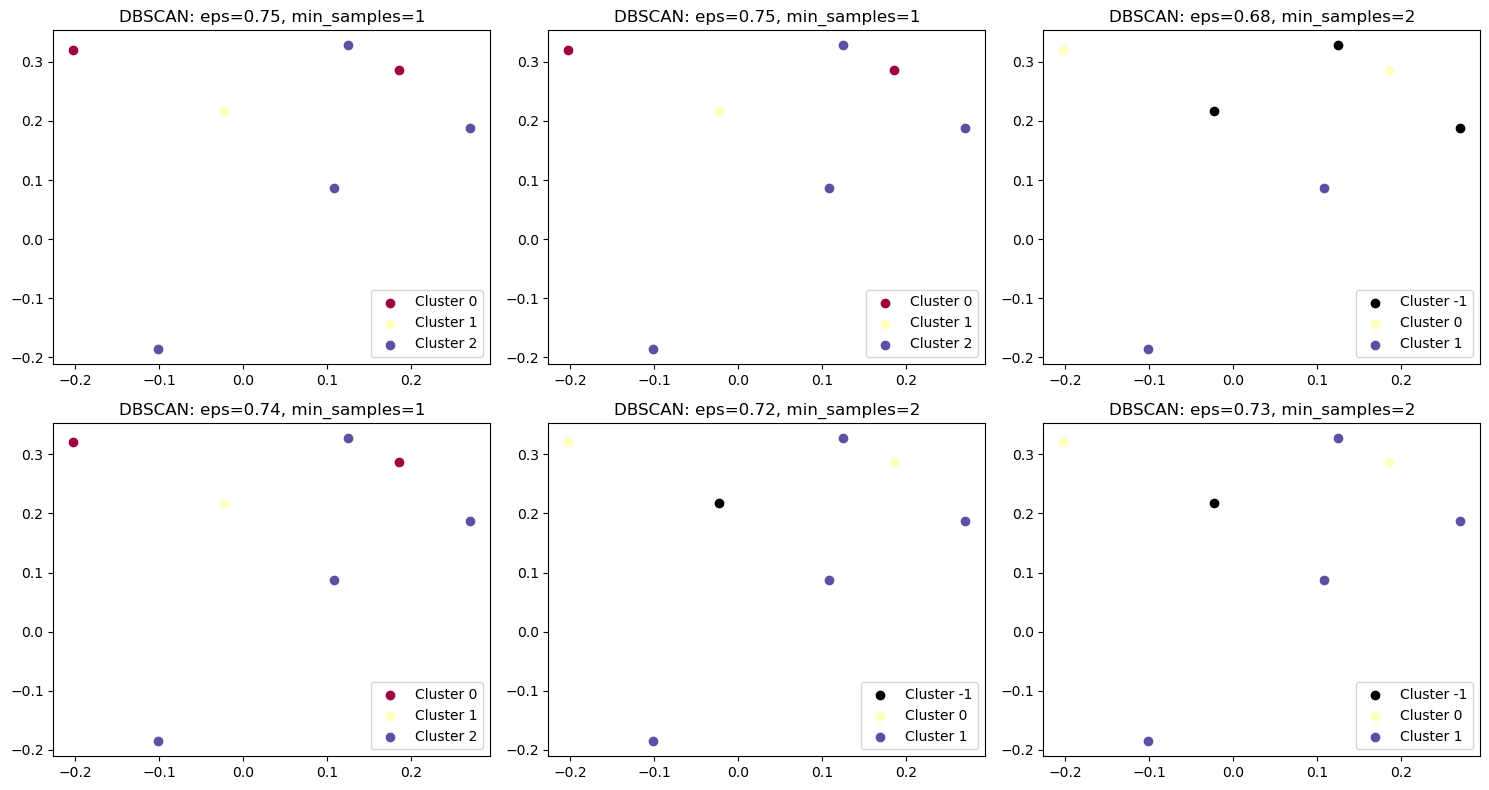

In [14]:
import numpy as np
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import random

from random import uniform, randint

random.seed(42)
np.random.seed(42)

n_samples = 6

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plot_count = 0

for ax in axes.flatten():
    while plot_count < n_samples:
        eps = uniform(0.2, 1)
        min_samples = randint(1, 3)
        
        dbscan_emb_labels = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit_predict(emb_sent_df)
        unique_labels = np.unique(dbscan_emb_labels)
    
        print(f"eps={eps}, min_samples={min_samples}: {unique_labels}")
        
        if len(unique_labels) == 3:
            print(f"eps={eps}, min_samples={min_samples}: {unique_labels}")
            
            colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
            
            for k, col in zip(unique_labels, colors):
                if k == -1:
                    col = [0, 0, 0, 1] 

                class_member_mask = (dbscan_emb_labels == k)
                xy = emb_sent_df[class_member_mask]
                ax.scatter(xy.iloc[:, 0], xy.iloc[:, 1], c=[col], label=f'Cluster {k}')
            
            ax.set_title(f'DBSCAN: eps={eps:.2f}, min_samples={min_samples}')
            ax.legend()
            plot_count += 1
            break

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
dbscan_emb_labels = DBSCAN(eps=0.70, min_samples=2, metric='cosine').fit_predict(emb_sent_df)

In [16]:
wiki_df["emb_dbscan"] = dbscan_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans,emb_dbscan
0,baguette food,It is distinguishable by its length and crisp crust.,10,1,2,0
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,2,2,0
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,0,0,-1
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,1,1,-1
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,1,1,1
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,1,1,-1
6,ice hockey,It belongs to a family of sports called hockey.,10,1,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Hierarchical clustering with sentence embedding representation
rubric={points}

**Your tasks:**

Try hierarchical clustering on `emb_sents`. In particular
1. Create and show a dendrogram with `complete` linkage and `metric='cosine'` on this toy dataset.
2. Create flat clusters using `fcluster` with appropriate hyperparameters and store cluster labels to `hier_emb_labels` variable below.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 3

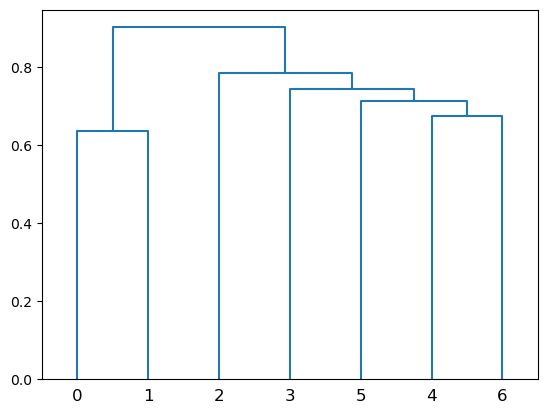

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

dendro = linkage(emb_sents, method='average', metric='cosine')
dendrogram(dendro, color_threshold=0.5)
plt.show()

In [18]:
hier_emb_labels = fcluster(dendro, 0.76, criterion='distance')

In [19]:
# hier_emb_labels = fcluster(Z, 3, criterion="maxclust") # alternative solution

In [20]:
wiki_df["emb_hierarchical"] = hier_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans,emb_dbscan,emb_hierarchical
0,baguette food,It is distinguishable by its length and crisp crust.,10,1,2,0,1
1,banana bread food,It is often a moist and sweet quick bread but some recipes are yeast raised.,16,2,2,0,1
2,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,0,0,-1,3
3,data science,"Data science also integrates domain knowledge from the underlying application domain (e.g., natural sciences, information technology, and medicine).",24,1,1,-1,2
4,sports analytics,"The term ""sports analytics"" was popularized in mainstream sports culture following the release of the 2011 film Moneyball.",21,1,1,1,2
5,football sport,"Often competitive and organized, sports use, maintain, or improve physical ability and skills.",17,1,1,-1,2
6,ice hockey,It belongs to a family of sports called hockey.,10,1,1,1,2


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.6 Discussion
rubric={points}

**Your tasks:**

1. Reflect on and discuss the clustering results of the methods you explored in the previous exercises, focusing on the following points:    
    - effect of input representation on clustering results
    - whether the clustering results match with your intuitions and the challenges associated with getting the desired clustering results with each method

<div class="alert alert-warning">

Solution_1.6
    
</div>

_Points:_ 4

1. KMeans: Overall, the clustering results differered from how I interpreted the clusters, perhaps because KMeans was not able to capture a more complicated cluster shape. KMeans was relatively easy to use once the number of expected groups was found.
   - Sentence Embeddings: this actually encodes the semantic information of the sentence in a higher dimension vector space, as such, the clusters are better quality and match the expected predictions better.
   - Bag of Words: this captures the frequency of common words appearing, which generally does not capture sematic context of the text well. As such, this lead to poorer quality clusters that deviated further from the expectation.
2. DBScan: arguably provided better clustering results compared to KMeans, as there was some degree of separation found for sports. However, the clustering results still do not match the intutition. The challenging part of DBScan is determining the hyperparameters to get good clustering results, I was able to achieve this by implementing a system similar to `RandomSearchCV`.
3. Heirarchical: provided the same clustering results as `emb_kmeans`, which is not the best and different from expected. The difficult part of this method was finding the distance separation metric that resulting in 3 distinct groups. Interpreting the graph with a little brute force was needed to find the metric. 

The difference in the clusters could be due to the fact that the text does not exactly match the wiki query semantically, since when I was initially creating the groups, I looked at the query to form the groups. Maybe having more text related to the queries will result in better clustering results.

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

### 1.7 Visualizing clusters
rubric={points:4}


One approach to working with unlabeled data is visualization. That said, our data is high-dimensional, making it challenging to visualize. Take sentence embedding representation as an example: each instance is depicted in 768 dimensions. To visualize such high-dimensional data, we can employ dimensionality reduction techniques to extract the most significant 2 or 3 components, and then visualize this low-dimensional data.

Given data as a `numpy` array and corresponding cluster assignments, the `plot_umap_clusters` function below transforms the data by applying dimensionality reduction technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to it and plots the transformed data with different colours for different clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the UMAP part.* 

You'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate cpsc330
> conda install -c conda-forge umap-learn
```
or

```
> conda activate cpsc330
> pip install umap-learn 
```

If you get an error with the import below try

```
pip install --upgrade numba umap-learn
```

**Your tasks:**

1. Visualize the clusters created by the methods above using `plot_umap_clusters` function below. In other words, visualize clusters identified by each of the methods below. 
    - K-Means with bag-of-words representation 
    - K-Means with sentence embedding representation
    - DBSCAN with sentence embedding representation 
    - Flat cluster of hierarchical clustering with sentence embedding representation     

In [21]:
import umap

In [22]:
def plot_umap_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
    ignore_noise=False,
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    if ignore_noise:
        umap_df = umap_df[umap_df["cluster"] != -1]

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        #edgecolors="k",
        #linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    if show_labels:
        x = umap_df["dim1"].tolist()
        y = umap_df["dim2"].tolist()
        for i, txt in enumerate(raw_sents):
            ax.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
    plt.show()

<div class="alert alert-warning">

Solution_1.7
    
</div>

_Points:_ 4

C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


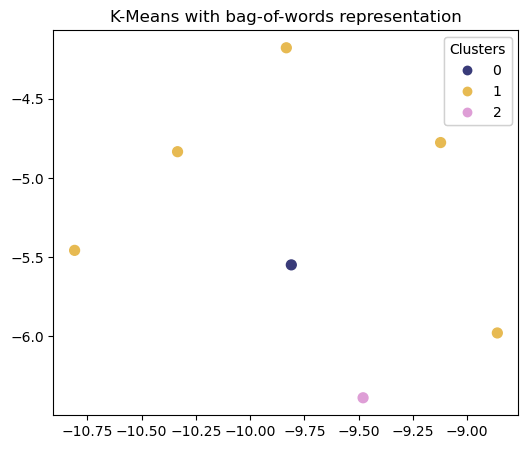

C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


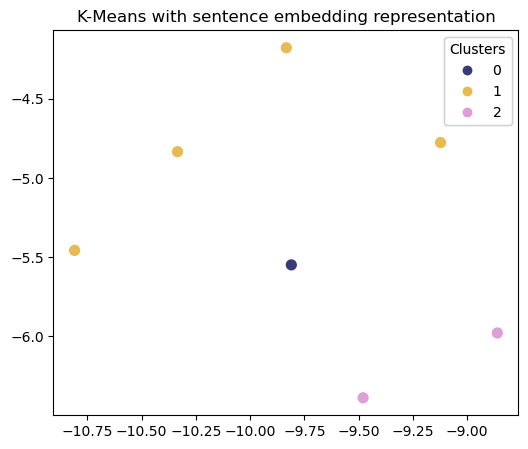

C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


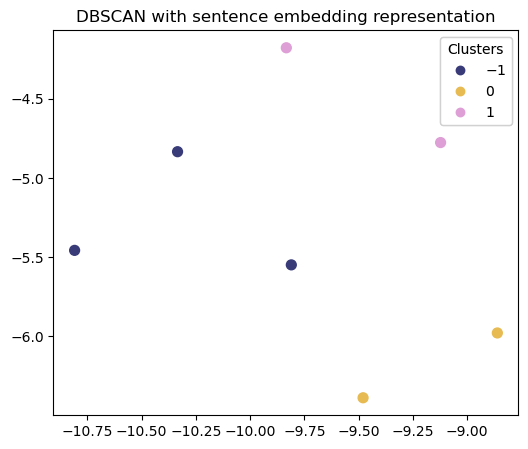

C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


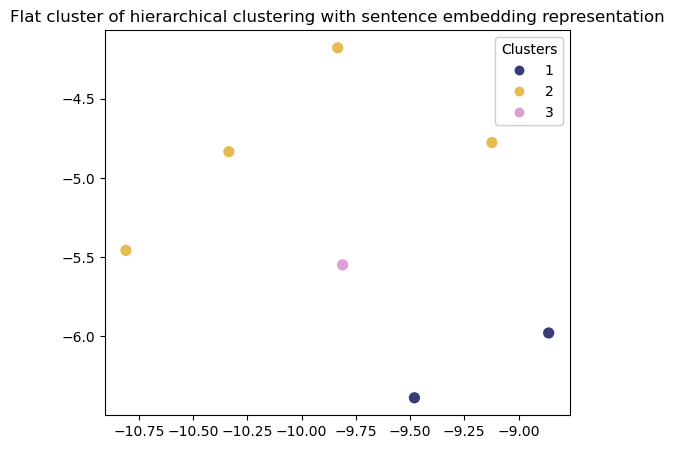

In [23]:
# 1. Visualize the clusters created by the methods above using `plot_umap_clusters` function below. In other words, visualize clusters identified by each of the methods below. 
#     - K-Means with bag-of-words representation 
#     - K-Means with sentence embedding representation
#     - DBSCAN with sentence embedding representation 
#     - Flat cluster of hierarchical clustering with sentence embedding representation     

plot_umap_clusters(
    emb_sents,
    wiki_df["bow_kmeans"],
    title="K-Means with bag-of-words representation",
)

plot_umap_clusters(
    emb_sents,
    wiki_df["emb_kmeans"],
    title="K-Means with sentence embedding representation",
)

plot_umap_clusters(
    emb_sents,
    wiki_df["emb_dbscan"],
    title="DBSCAN with sentence embedding representation",
)

plot_umap_clusters(
    emb_sents,
    wiki_df["emb_hierarchical"],
    title="Flat cluster of hierarchical clustering with sentence embedding representation",
)


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: [Food.com](https://www.food.com/) recipes 
<hr>

Now that we have applied document clustering on a toy corpus, let's move to a more realistic corpus. 

In the lecture, we worked on an activity of manually clustering food items and discussed challenges associated with it. We also applied different clustering algorithms to cluster food images. We'll continue this theme of clustering food items in this lab. But instead of images we will cluster textual description of food items, i.e., recipe names.   

In this lab, we will work with a sample of [Kaggle's Food.com recipes corpus](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions). This corpus contains 180K+ recipes and 700K+ recipe reviews. In this lab, we'll only focus on recipes and **not** on reviews. The recipes are present in `RAW_recipes.csv`. Our goal is to find categories or groupings of recipes from this corpus based on their names. 

**Your tasks:**

- Download [`RAW_recipes.csv`](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv) and put it under the `data` directory in the homework folder. 
- Run the code below. The dataset is quite large, and in this assignment, for speed, you will work with a sample of the dataset. The function `get_recipes_sample` below carries out some preliminary preprocessing and returns a sample of the recipes with most frequent tags. 

> *Note: Depending upon the capacity of your computer, feel free to increase or decrease the size of this sample by changing the value for `n_tags`. If you decide to go with a different value of `n_tags`, state it clearly in Exercise 2.1 so that the grader knows about it.* 

In [24]:
orig_recipes_df = pd.read_csv("data/RAW_recipes.csv")
orig_recipes_df.shape

(231637, 12)

In [25]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [26]:
recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(9100, 12)

In [27]:
recipes_df["name"]

42        i yam what i yam  muffins    
101       to your health  muffins      
129       250 00 chocolate chip cookies
138       lplermagronen                
163       california roll   salad      
                   ...                 
231514    zucchini blueberry bread     
231539    zucchini parmesan pancakes   
231547    zucchini salsa burgers       
231596    zuppa toscana                
231629    zydeco salad                 
Name: name, Length: 9100, dtype: object

<br><br>

**In the rest of the homework, we will use `recipes_df` above, which is a subset of the original dataset.** 

<br><br>

<!-- BEGIN QUESTION -->

### 2.1 Longest and shorter recipe names 
rubric={points:2}

**Your tasks:**

1. Print the shortest and longest recipe names (length in terms of number of characters) from `recipes_df`. If there is more than one recipe with the same shortest/longest length, store **one** of them in `shortest_recipe` and/or `longest_recipe` as a **string**.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 2

In [28]:
shortest_recipe = recipes_df.loc[recipes_df["name"].apply(len).idxmin(), "name"]
longest_recipe = recipes_df.loc[recipes_df["name"].apply(len).idxmax(), "name"]

shortest_recipe, longest_recipe

('bread', 'baked tomatoes with a parmesan cheese crust and balsamic drizzle')

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 More EDA
rubric={points:2}

**Your tasks:**
1. Create a word cloud for the recipe names. You can use [the `wordcloud` package](https://github.com/amueller/word_cloud) for this, which you will have to install in the course environment.
```
> conda activate cpsc330
> conda install -c conda-forge wordcloud
```

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 2

In [29]:
import wordcloud

def plot_wordcloud(text, title=""):
    wc = wordcloud.WordCloud(width=800, height=400, max_words=200).generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(" ".join(recipes_df["name"]), title="Word cloud of recipe names")

ModuleNotFoundError: No module named 'wordcloud'

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Representing recipe names
rubric={points:3}

The next step is creating a representation of recipe names. 

**Your tasks:**

1. Similar to Exercise 1, create sentence embedding representation of recipe names (`name` column in `recipes_df`).  For the rest of the homework, we'll stick to the sentence embedding representation of recipe names.


> You might have to convert the recipe names to a list (`recipes_df["name"].tolist()`) for the embedder to work
> *If you create a dataframe with sentence embedding representation, set the index to `recipes_df.index` so that the indices match with the indices of the sample we are working with.*  
> **This might take a while to run.**


<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 3

In [30]:
embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")
embeddings = embedder.encode(recipes_df["name"].tolist())
emb_recipe_df = pd.DataFrame(embeddings, index=recipes_df.index)

In [42]:
emb_recipe_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
42,-0.333474,0.227864,-0.307339,0.410549,0.917104,-0.345507,0.305810,0.256676,-0.147711,0.040728,...,-0.053024,-0.209463,0.362418,-0.246085,0.208379,-0.024874,0.506561,0.197738,-0.386422,-0.002183
101,-0.024523,0.246223,-0.055709,0.358273,0.454786,-0.088054,0.260368,0.231947,0.093013,-0.007834,...,0.144860,-0.435459,0.208344,-0.002655,-0.081200,-0.130489,0.452378,0.186310,-0.278501,0.028580
129,-0.026562,0.194671,0.038101,-0.099181,0.653784,-0.230868,0.064517,0.001376,-0.061280,0.232095,...,0.169605,0.239355,0.392649,0.271398,-0.093971,0.060101,-0.281417,0.133210,-0.122344,-0.109864
138,-0.168002,-0.219219,0.330761,0.302196,-0.173169,0.204557,0.192390,0.140975,0.303174,0.038063,...,0.019094,-0.002448,0.437833,0.563785,0.033443,0.187657,0.529252,-0.233786,0.509931,0.410715
163,0.061076,-0.333798,0.242905,0.395978,-0.466468,0.496504,-0.136754,0.122097,0.114249,0.065318,...,0.044438,-0.213657,0.410352,-0.233599,-0.224422,0.094331,0.173351,0.105781,-0.114749,-0.150678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231514,-0.106531,-0.034574,0.160071,0.258504,0.882480,0.091899,0.008815,0.372013,-0.266542,0.085018,...,0.063240,-0.099133,0.332694,0.031868,0.582796,0.216874,0.241107,0.091759,-0.261551,-0.082310
231539,0.032241,0.358776,0.035928,0.159231,0.446191,0.005988,-0.120629,-0.011145,-0.200736,-0.138867,...,0.129480,-0.087242,0.571368,-0.039195,0.228918,0.307089,0.014225,-0.536663,-0.086178,0.022649
231547,0.016149,-0.053036,-0.035097,-0.021835,0.735161,0.245519,-0.151837,0.003954,0.102566,0.001362,...,0.102296,0.023821,0.602685,-0.067071,0.177534,0.253982,0.242439,-0.436001,-0.053910,0.012423
231596,0.026659,0.202483,0.344634,-0.138708,0.514423,0.630947,-0.003165,-0.102897,-0.434900,-0.192056,...,-0.162457,0.130696,0.113645,0.186649,-0.155392,0.130507,1.146238,-0.240861,0.236831,0.177123


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 3: Clustering recipe names
<hr>

In this exercise you'll cluster recipe names with some of the clustering algorithms we have seen in class. This will also involve making some attempts to pick reasonable hyperparameter values for each clustering method based on the quality of the resulting clusters. For example, for KMeans, you need to specify the number of clusters in advance, which is often challenging on real-world datasets. For DBSCAN, you need to pick appropriate `eps` and `min_samples`. For hierarchical clustering, you need to pick a suitable linkage criterion, distance metric, and prune the tree so that it's possible to visualize and interpret it. 

Here are some methods which may help you with picking reasonable values for the hyperparameters. 
- Visualize the Elbow plot (KMeans). 
- Visualize Silhouette plots. 
- Visualize resulting clusters using `plot_umap_clusters` function from Exercise 1. 
- Sample some recipes from each cluster, manually inspect whether there are coherent semantic themes. (For this, you may use the function `print_clusters` given below.) 
        
> You may use the [`yellowbrick`](https://www.scikit-yb.org/en/latest/) package for visualizing the Elbow plot and the Silhouette plots. You can intall it with

```conda install -c districtdatalabs yellowbrick```

**Note that the process of picking reasonable hyperparameter values will be exploratory, iterative, and will involve manual inspection and judgment, as there is no ground truth to verify how well the model is doing. In your solutions, please do not include everything you try. Only present the results of the most informative trials. Add a narrative to your answer so that it's easy for the grader to follow your choices and reasoning.** 

In [31]:
def print_clusters(recipes_df, cluster_labels, n_recipes=10, replace=False, random_state=None):
    """
    Given recipes_df containing recipe names and cluster assignment (labels), 
    sample and print n_recipes recipes per cluster. 

    Parameters
    -----------
    recipe_df : pandas dataframe 
        recipes dataframe containing recipe names in the "name" column
    cluster_labels : ndarray or a list
        cluster labels for each row in recipes_df 
    n_recipes : int
        number of examples to sample from each cluster
    replace: bool
        replace flag to pass to the sampling of recipe names

    Returns
    -----------
    None
    """    
    
    grouped = (
        pd.DataFrame(
            {
                "name": recipes_df["name"],
                "cluster_label": cluster_labels,
            }
        )
        .sort_values("cluster_label")
        .groupby("cluster_label")    
    )
    
    for name, group in grouped:
        print(f"Cluster {name}")        
        print(("----------").format(""))        
        print("\n".join(group.sample(n_recipes, random_state=random_state)['name'].tolist()))
        print("\n\n")

<br><br>

<!-- BEGIN QUESTION -->

### 3.1 K-Means
rubric={points:6}

**Your tasks:**

1. Cluster recipe titles using KMeans. Make some attempts to determine the optimal number of clusters. 
2. Pick one or two best models and justify your choice. 

<div class="alert alert-warning">

Solution_3.1
    
</div>

_Points:_ 6

I selected the k-value 28 using the elbow method where we get the best 'bang for our buck' without overfitting too hard on the data, but still getting a decent decent distortion scores which represent within cluster errors.

Since we tested both K=27, and 29, we can just select k = 28 according to KElbowVisualizer. 



In [ ]:
k_values = [1, 3, 5, 10, 50, 100, 500, 1000, 1500]
# Smaller Values of K are deceivingly correct.
# When i just had 100 as my max K value, 28 worked best, now its grim AF
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=k_values)

visualizer.fit(emb_recipe_df) 
visualizer.show();
    
    

In [39]:
kmeans = KMeans(n_init='auto', n_clusters=28)
clusters = kmeans.fit_predict(emb_recipe_df)

In [40]:
print_clusters(recipes_df, clusters)

Cluster 0
----------
our favorite tzatziki sauce
nif s chili to take the chill off  vegetarian or vegan
pickle sauce  michael smith
moo shu vegetables
stuffed green bell  peppers
kelly s  chunky  haystacks
figs wrapped in country ham
mexicana rice
weight watchers peanut sauce
pumpkin chilli



Cluster 1
----------
two brother s chocolate gobs
banana cupcakes
lannette s chocolate macaroon tunnel cake
lemon yogurt cake  ina garten
ina clara chocolate cake
sour cream cinnamon cupcakes
my husband s fave blueberry coffee cake
sunsweet s fudgy chocolate cake
chocolate fire cake
chocolate cake w  vanilla sauce



Cluster 2
----------
chef boy i be illinois  baked cod casserole
polenta casserole with sauteed bell peppers and sausage
quick and easy lasagna
angel food torte
deviled ham   egg casserole
creamy alfredo with tofu shirataki
baked monte cristo sandwich
it s a keeper casserole
tater tot  beef   cheese casserole
my family s favorite chili



Cluster 3
----------
pat s chocolate cookies


C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


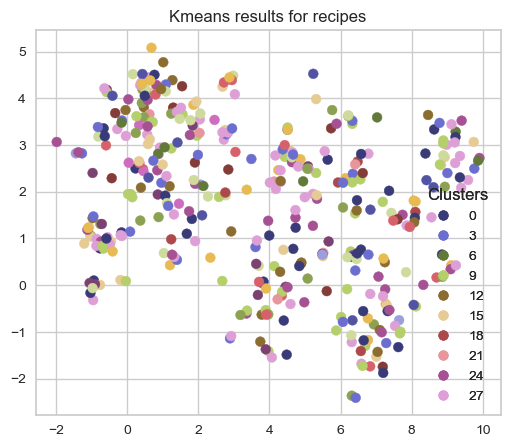

In [37]:
recipes_df["emb_KMeans"] = clusters

plot_umap_clusters(
    emb_recipe_df,
    recipes_df["emb_KMeans"],
    title="Kmeans results for recipes",
)


In [ ]:
...

<!-- END QUESTION -->

<br><br><br><br>

<!-- BEGIN QUESTION -->

### 3.2 DBSCAN
rubric={points:6}

**Your tasks:**

1. Cluster recipe names using `DBSCAN` with `metric="cosine"`. Make some attempts to tune the  hyperparameters `eps` and `min_samples`. 

<div class="alert alert-warning">

Solution_3.2
    
</div>

_Points:_ 6

_Type your answer here, replacing this text._

In [ ]:
from sklearn.model_selection import ParameterGrid
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

param_dist = {
    'eps': np.linspace(1, 10, 5),
    'min_samples': np.arange(1, 50, 10)
}

dbscan = DBSCAN()

#This takes a million years (20 minutes) to run for just 1 single iteration of DBSCAN. 
random_search = RandomizedSearchCV(
    dbscan,
    param_distributions=param_dist,
    n_iter=10,
    scoring='silhouette_score',
    n_jobs=-1,
    cv=1
)

random_search.fit(emb_recipe_df)

best_params = random_search.best_params_
best_score = random_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score:.2f}")

best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
visualizer = SilhouetteVisualizer(best_dbscan, colors="yellowbrick")
visualizer.fit(X)
visualizer.show()

silhouette_score = visualizer.silhouette_score_
print(f"Silhouette Score: {silhouette_score:.2f}")

In [ ]:
recipes_df["emb_dbscan"] = best_dbscan
recipes_df

In [ ]:
plot_umap_clusters(
    emb_recipe_df,
    recipes_df["emb_dbscan"],
    title="DBSCAN Results for recipes",
)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Hierarchical clustering
rubric={points:6}

**Your tasks:**

1. Try hierarchical clustering with `metric="cosine"` on this problem. Show a dendrogram by using a suitable truncation method. 
2. Create flat clusters by cutting the tree at the appropriate level. 

> *Note: Try orientation="left" of `dendrogram` for better readability of the dendrogram.*

<div class="alert alert-warning">

Solution_3.3
    
</div>

_Points:_ 6

_Type your answer here, replacing this text._

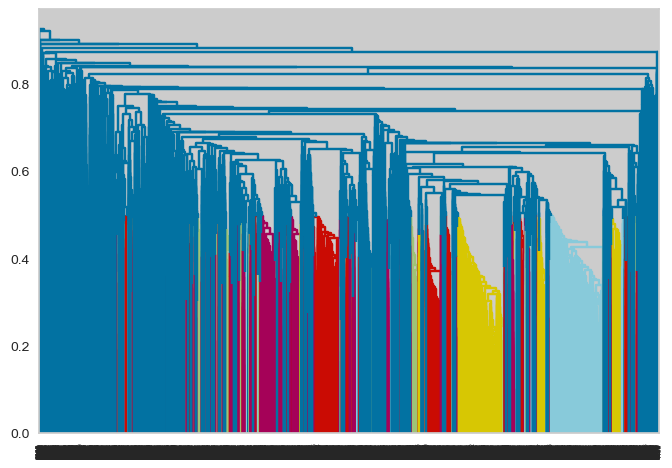

In [43]:
dendro = linkage(emb_recipe_df, method='average', metric='cosine')
dendrogram(dendro, color_threshold=0.5)
plt.show()

In [45]:

hier_emb_labels_recipes = fcluster(dendro, 0.5, criterion='distance')

In [46]:
recipes_df["emb_hierarchical"] = hier_emb_labels_recipes
recipes_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,emb_KMeans,emb_hierarchical
42,i yam what i yam muffins,93958,45,133174,2004-06-22,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[171.8, 9.0, 28.0, 10.0, 8.0, 4.0, 8.0]",10,"['preheat oven to 375 degrees', 'spray muffin tin with non-stick cooking spray and set aside', 'place the raisins in a small bowl and pour the 1 / 4 cup boiling water over them', 'cover and set aside while preparing batter', 'combine the flours , cocoa , baking powder , cinnamon , cloves , baking soda , and salt', 'lightly beat eggs with sorghum , oil , mashed yams and orange juice', 'add the egg mixture and buttermilk alternately to the dry ingredients , stir until well blended', 'drain the raisins and add to batter along with orange peel', 'spoon batter into prepared muffin tins , sprinkle 1 / 4 to 1 / 2 tsp of granulated sugar over each muffin', 'bake in preheated oven for 15 to 20 minutes']","these muffins may have slightly different ingredients but the end result is a wonderful rich, moist muffin. the sugar sprinkled on top before cooking gives a slightly sweet crunch and cracked glazed appearance.","['all-purpose flour', 'buckwheat flour', 'unsweetened cocoa', 'baking powder', 'baking soda', 'salt', 'ground cinnamon', 'ground cloves', 'sorghum', 'eggs', 'yam', 'low-fat buttermilk', 'orange rind', 'orange juice', 'canola oil', 'raisins', 'boiling water', 'granulated sugar']",18,17,1442
101,to your health muffins,61973,40,33823,2003-05-12,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[159.0, 8.0, 58.0, 10.0, 7.0, 4.0, 8.0]",5,"['blend together in large bowl flour , bran , brown sugar , baking soda , salt , cinnamon , carrots and raisins', 'in second bowl , beat buttermilk , oil , egg and vanilla', 'add liquid ingredients to dry ingredients and mix just until moistened', 'spoon into 12 greased or paper-lined muffin cups', 'bake at 375f for 20 minutes']","these muffins sound like they are very healthy for you, and pretty easy to make. another one of my great finds. to your health. enjoy","['whole wheat flour', 'natural bran', 'brown sugar', 'baking soda', 'salt', 'cinnamon', 'carrot', 'raisins', 'buttermilk', 'corn oil', 'egg', 'vanilla']",12,17,1442
129,250 00 chocolate chip cookies,118843,20,145599,2005-04-24,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'drop-cookies', 'desserts', 'easy', 'cookies-and-brownies', '3-steps-or-less']","[5286.9, 427.0, 1630.0, 159.0, 163.0, 656.0, 224.0]",3,"['mix all ingredients together just until blended', 'spoon large tbspfuls onto a baking sheet', 'bake at 350 for 10-14 minutes']",these are great! the perfect name for them!,"['butter', 'white sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'oatmeal', 'salt', 'baking powder', 'baking soda', 'chocolate chips', ""hershey's semi-sweet baking chocolate"", 'nuts']",13,1,1469
138,lplermagronen,455351,55,1308592,2011-05-07,"['60-minutes-or-less', 'time-to-make', 'preparation']","[651.8, 33.0, 12.0, 16.0, 32.0, 63.0, 33.0]",15,"['heat oven to 375f set a large pot of salted water to boil', 'heat butter / oil over medium-low heat in a frying pan', 'add onions and fry them until golden brown', 'add penne and potatoes to the salted water', 'stir to make sure pasta doesnt stick together', 'cook until tender , about 15 minutes', 'drain penne and potatoes', 'combine milk / cream with salt and pepper', 'in an ovenproof casserole dish , place 1 / 3 of the penne-potatoes , sprinkle with 1 / 2 of the grated cheese', 'make another layer with 1 / 3 of the penne-potatoes , sprinkle with the other 1 / 2 of the grated cheese', 'top with the remaining 1 / 3 of the penne-potatoes', 'pour the seasoned milk / cream evenly over the top', 'spread the browned onions on top', 'bake covered for 10-15 minutes until steaming hot and cheese is melted', 'serve w

C:\Users\cedar\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


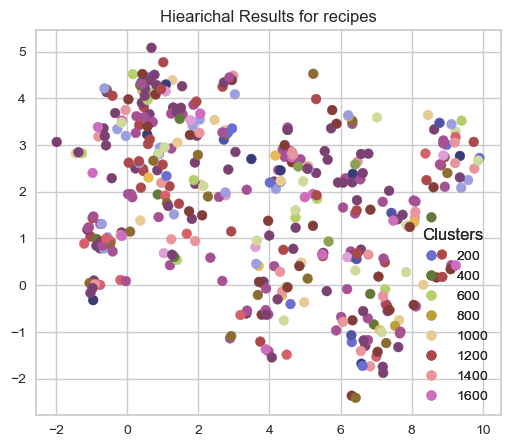

In [47]:
plot_umap_clusters(
    emb_recipe_df,
    recipes_df["emb_hierarchical"],
    title="Hiearichal Results for recipes",
)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.4 Manual interpretation of clusters
rubric={points:6}

**Your tasks:**

1. Label the topics/themes you see in the clusters created by different clustering methods.  
2. Do you see a common theme across clusters created by different clustering methods? Do you see any differences between the clusters created by different clustering methods? 

<div class="alert alert-warning">

Solution_3.4
    
</div>

_Points:_ 6

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<br><br><br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)